For the Maven Healthcare Challenge, you'll be working as a Data Analyst for the American Hospital Association (AHA), a national organization that represents hospitals and their patients, and acts as a source of information on health care issues and trends.

As part of your role, you've been asked to analyze the Hospital Consumer Assessment of Healthcare Providers and Systems (HCAHPS) survey results for the last 9 years. The intent of the HCAHPS initiative is to provide a standardized survey instrument for measuring patients’ perspectives on hospital care, and one of its 3 main goals is to "create incentives for hospitals to improve their quality of care".

Your task is to evaluate whether the HCAHPS survey has been successful in accomplishing this goal by answering questions like these:

- Have hospitals' HCAHPS scores improved over the past 9 years?
- Are there any specific areas where hospitals have made more progress than others?
- Are there any major areas of opportunity remaining?
- What recommendations can you make to hospitals to help them further improve the patient experience?


HCAHPS Patient Survey
National & state-level scores from 2013 to 2022 for the Hospital Consumer Assessment of Healthcare Providers and Systems (HCAHPS) survey, a national, standardized survey of hospital patients about their experiences during a recent inpatient hospital stay.

https://mavenanalytics.io/challenges/maven-healthcare-challenge/26


https://www.qualtrics.com/experience-management/customer/net-promoter-score/

# Maven Healthcare Challenge

This is project is my submission for the [Maven Healthcare Challenge](https://mavenanalytics.io/challenges/maven-healthcare-challenge/26). My goal is to analyze the Hospital Consumer Assessment of Healthcare Providers and Systems (HCAHPS) survey data and determine if it was able to 
improve quality of care and service to patients. 

The HCAHPS survey is required by the Centers for Medicare and Medicaid Services (CMS) for all hospitals in the United States and is used to measure patients' perspectives on hospital care. The results are made public to encourage hospitals to improve their quality of care and service to patients, and to empower patients to make informed decisions about where they receive care.



# Exploratory Data Analysis
I started by reviewing the provided data dictionary to have a better understanding of the data. The dataset contained multiple tables across 7 CSV files, 23 columns, and 47889 rows. Required packages were imported and the dataset was read into dataframes. 

Initial review of the data revealed a `Release Period` column in multiple tables corresponding to the year the data was collected. This column was trimmed and converted to a datetime type. 

The `national_results` and `state_results` table both contained the columns `Bottom-box Percentage`, `Middle-box Percentage`, and `Top-box Percentage`, which corresponds to the percentage of patients who had a negative, neutral, or positive experience, respectively. We can use these columns to calculate the [Net Promoter Score (NPS)](https://www.qualtrics.com/experience-management/customer/net-promoter-score/), which measures patient experience and satisfaction. NPS is calculated by subtracting detractors (Botton-box Percentage) from promoters (Top-box Percentage).
>NPS = [Top-box Percentage] - [Bottom-box Percentage]

In [21]:
# Import packages
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
import os
import plotly.express as px
import plotly.io as pio
from pandas.tseries.offsets import DateOffset
import geopandas as gpd


In [14]:
# Read CSV files into dictionary
directory_path = 'data_tables/'
file_paths = [os.path.join(directory_path, file) for file in os.listdir(directory_path) if file.endswith('.csv')]
dataframes = {os.path.basename(file).replace('.csv', ''): pd.read_csv(file) for file in file_paths}


## National Results

A line plot of mean NPS over each year was created to visualize the change in score over time. We see a gradual increase in score until 2021 when the score began to decline.

Further evaluation at the measure ID level revealed `H_COMP_5` and `H_COMP_7` at a noticeably lower score compared to the other measures. 
- **H_COMP_5: Communication about Medicines**
    - Before giving you any new medicine, how often did hospital staff tell you what the medicine was for? 
    - Before giving you any new medicine, how often did hospital staff describe possible side effects in a way you could understand? 
- **H_COMP_7: Care Transition**
    - During this hospital stay, staff took my preferences and those of my family or caregiver into account in deciding what my health care needs would be when I left. 
    - When I left the hospital, I had a good understanding of the things I was responsible for in managing my health. 
    - When I left the hospital, I clearly understood the purpose for taking each of my medications. 
The two measures correspond to the communication between hospital staff and patients, and may be a possible area to improve on. 


In [36]:
national_results = pd.read_csv('data_tables/national_results.csv')

#Convert release period to datetime
national_results['Release Period'] = pd.to_datetime(national_results['Release Period'].str.lstrip('07_'))
national_results.columns = national_results.columns.str.lower().str.replace(' ', '_')
national_results['nps'] = national_results['top-box_percentage'] - national_results['bottom-box_percentage']

national_results.head()

,release_period,measure_id,bottom-box_percentage,middle-box_percentage,top-box_percentage,nps
0,2015-01-01,H_CLEAN_HSP,8,18,74,66
1,2015-01-01,H_COMP_1,4,17,79,75
2,2015-01-01,H_COMP_2,4,14,82,78
3,2015-01-01,H_COMP_3,9,23,68,59
4,2015-01-01,H_COMP_5,18,17,65,47


In [40]:

national_results_avg = national_results.groupby('release_period')['nps'].agg(['mean', 'median', 'std']).reset_index()
national_results_avg

,release_period,mean,median,std
0,2015-01-01,62.6,64.5,11.027239
1,2016-01-01,63.0,65.0,11.362707
2,2017-01-01,63.7,66.0,11.106054
3,2018-01-01,64.0,66.5,10.893423
4,2019-01-01,63.8,66.0,10.891383
5,2020-01-01,64.2,66.0,10.788883
6,2021-01-01,64.4,66.5,10.936178
7,2022-01-01,61.5,64.0,11.247222
8,2023-01-01,59.8,61.5,11.717034


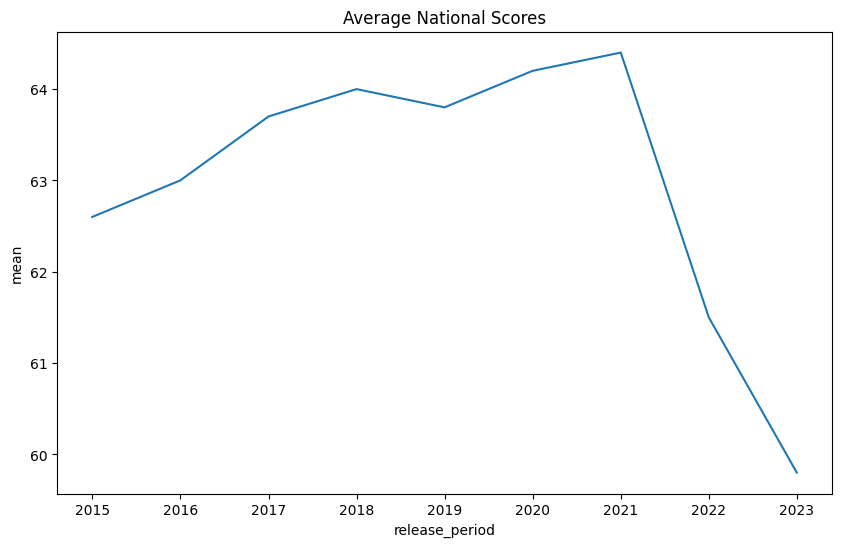

In [46]:
# Plot average national scores over time
plt.figure(figsize=(10, 6))
sns.lineplot(data=national_results_avg, x='release_period', y='mean')
plt.title('Average National Scores')
plt.show()


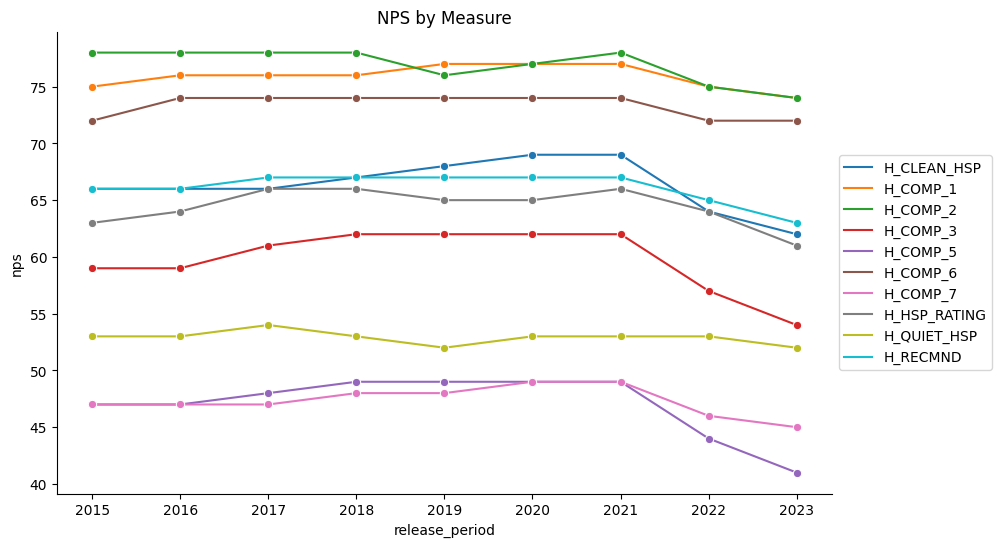

In [44]:
# NPS change over time by measure ID
plt.figure(figsize=(10, 6))
ax = sns.lineplot(data=national_results, x='release_period', y='nps', hue='measure_id', errorbar=None, marker='o')
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.title('NPS by Measure')
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
plt.show()

## State

In [15]:
# 
# state_results = pd.read_csv('data_tables/state_results.csv')
state_results = dataframes['state_results']
state_results['Release Period'] = pd.to_datetime(state_results['Release Period'].str.lstrip('07_'))
state_results.columns = state_results.columns.str.lower().str.replace(' ', '_')
# state_results['nps'] = state_results['top-box_percentage'] - state_results['bottom-box_percentage']
state_results.head()

,release_period,state,measure_id,bottom-box_percentage,middle-box_percentage,top-box_percentage
0,2015-01-01,AK,H_CLEAN_HSP,8,22,70
1,2015-01-01,AK,H_COMP_1,9,17,74
2,2015-01-01,AK,H_COMP_2,10,15,75
3,2015-01-01,AK,H_COMP_3,11,21,68
4,2015-01-01,AK,H_COMP_5,19,17,64


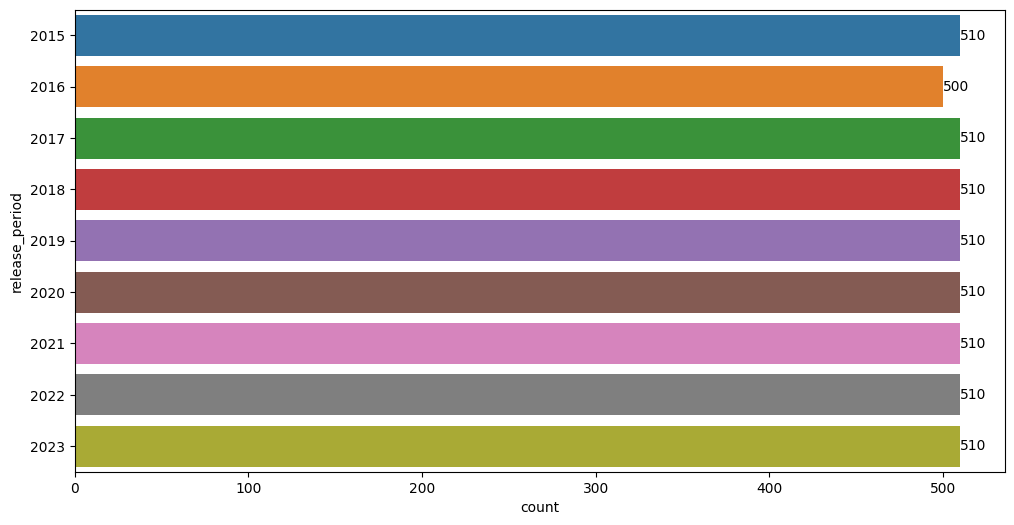

In [4]:
# Count of states by year; find missing data
year = state_results.release_period.dt.year
plt.figure(figsize=(12, 6))
ax = sns.countplot(data=state_results, y=year)
for label in ax.containers:
    ax.bar_label(label)
plt.show()

In [16]:
# Interpolate missing MD 2016 data
# New dataframes for MD 2015 and 2017 data
df = state_results.copy()
md_2015 = df[(df.state == 'MD') & (df.release_period == '2015-01-01')]
md_2017 = df[(df.state == 'MD') & (df.release_period == '2017-01-01')]

# Interpolate 2016 data using average of 2015 and 2017 data
md_inter = md_2015.copy()
for col in ['bottom-box_percentage', 'middle-box_percentage', 'top-box_percentage']:
    md_inter[col] = (md_2015[col].values + md_2017[col].values) / 2
md_inter['release_period'] = md_inter['release_period'] + DateOffset(years=1)

# Concatenate interpolated data with original dataframe
state_results = pd.concat([state_results, md_inter], ignore_index=True)
state_results

,release_period,state,measure_id,bottom-box_percentage,middle-box_percentage,top-box_percentage
0,2015-01-01,AK,H_CLEAN_HSP,8.0,22.0,70.0
1,2015-01-01,AK,H_COMP_1,9.0,17.0,74.0
2,2015-01-01,AK,H_COMP_2,10.0,15.0,75.0
3,2015-01-01,AK,H_COMP_3,11.0,21.0,68.0
4,2015-01-01,AK,H_COMP_5,19.0,17.0,64.0
...,...,...,...,...,...,...
4585,2016-01-01,MD,H_COMP_6,14.0,0.0,86.0
4586,2016-01-01,MD,H_COMP_7,7.0,45.0,48.0
4587,2016-01-01,MD,H_HSP_RATING,10.0,25.0,65.0
4588,2016-01-01,MD,H_QUIET_HSP,12.0,30.5,57.5


In [17]:
# Calculate NPS
state_results['nps'] = state_results['top-box_percentage'] - state_results['bottom-box_percentage']
state_results

,release_period,state,measure_id,bottom-box_percentage,middle-box_percentage,top-box_percentage,nps
0,2015-01-01,AK,H_CLEAN_HSP,8.0,22.0,70.0,62.0
1,2015-01-01,AK,H_COMP_1,9.0,17.0,74.0,65.0
2,2015-01-01,AK,H_COMP_2,10.0,15.0,75.0,65.0
3,2015-01-01,AK,H_COMP_3,11.0,21.0,68.0,57.0
4,2015-01-01,AK,H_COMP_5,19.0,17.0,64.0,45.0
...,...,...,...,...,...,...,...
4585,2016-01-01,MD,H_COMP_6,14.0,0.0,86.0,72.0
4586,2016-01-01,MD,H_COMP_7,7.0,45.0,48.0,41.0
4587,2016-01-01,MD,H_HSP_RATING,10.0,25.0,65.0,55.0
4588,2016-01-01,MD,H_QUIET_HSP,12.0,30.5,57.5,45.5


## Map

In [25]:
gdf = gpd.read_file('shapefiles\cb_2022_us_state_20m.shp')
gdf.head()

,STATEFP,STATENS,AFFGEOID,GEOID,STUSPS,NAME,LSAD,ALAND,AWATER,geometry
0,48,01779801,0400000US48,48,TX,Texas,00,676685555821,18974391187,"POLYGON ((-106.62345 31.91403, -106.63011 31.9..."
1,06,01779778,0400000US06,06,CA,California,00,403673617862,20291712025,"MULTIPOLYGON (((-118.59397 33.46720, -118.4847..."
2,21,01779786,0400000US21,21,KY,Kentucky,00,102266581101,2384240769,"POLYGON ((-89.54443 36.57451, -89.47935 36.566..."
3,13,01705317,0400000US13,13,GA,Georgia,00,149486268417,4418716153,"POLYGON ((-85.60516 34.98468, -85.47434 34.983..."
4,55,01779806,0400000US55,55,WI,Wisconsin,00,140292518676,29343193162,"MULTIPOLYGON (((-86.93428 45.42115, -86.83575 ..."


<Axes: >

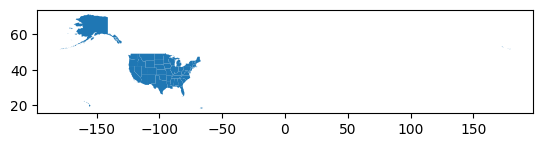

In [26]:
gdf.plot()

In [18]:
# Pivot table to show NPS by year
df_nps = state_results.pivot_table(index=['measure_id', 'state'], 
                                   columns=state_results['release_period'].dt.year, 
                                   values='nps').rename_axis(None, axis=1).sort_values(by=['state', 'measure_id'], ascending=True).reset_index()

# df_nps = p_table.sort_values(by=['state', 'measure_id'], ascending=True)
df_nps

,measure_id,state,2015,2016,2017,2018,2019,2020,2021,2022,2023
0,H_CLEAN_HSP,AK,62.0,65.0,64.0,67.0,63.0,67.0,62.0,62.0,69.0
1,H_COMP_1,AK,65.0,74.0,73.0,75.0,76.0,74.0,74.0,74.0,77.0
2,H_COMP_2,AK,65.0,79.0,76.0,75.0,74.0,78.0,77.0,75.0,77.0
3,H_COMP_3,AK,57.0,67.0,63.0,67.0,60.0,66.0,70.0,55.0,57.0
4,H_COMP_5,AK,45.0,49.0,50.0,49.0,48.0,49.0,50.0,47.0,47.0
...,...,...,...,...,...,...,...,...,...,...,...
505,H_COMP_6,WY,78.0,78.0,78.0,74.0,74.0,74.0,74.0,76.0,72.0
506,H_COMP_7,WY,47.0,47.0,48.0,51.0,50.0,51.0,52.0,49.0,49.0
507,H_HSP_RATING,WY,58.0,63.0,65.0,63.0,63.0,65.0,64.0,64.0,64.0
508,H_QUIET_HSP,WY,54.0,57.0,58.0,54.0,54.0,55.0,54.0,58.0,60.0


In [14]:
# # Create new dataframe with NPS change over time
# df = state_results.copy()
# df.release_period = df.release_period.dt.year
# year_list = df.release_period.unique().tolist()

# nps_change = df[df.release_period == 2023]
# for year in year_list:
#     a = df[df.release_period == year]
#     nps_change = pd.merge(nps_change,
#                    a[['state', 'measure_id', 'nps']],
#                    on=['state', 'measure_id'],
#                    how='left',
#                    suffixes=('', '_'+str(year))
#                    )
    
# nps_change.drop(columns=['bottom-box_percentage', 'middle-box_percentage', 'top-box_percentage', 'nps'], inplace=True)
# nps_change

,release_period,state,measure_id,nps_2015,nps_2016,nps_2017,nps_2018,nps_2019,nps_2020,nps_2021,nps_2022,nps_2023
0,2023,AK,H_CLEAN_HSP,62.0,65.0,64.0,67.0,63.0,67.0,62.0,62.0,69.0
1,2023,AK,H_COMP_1,65.0,74.0,73.0,75.0,76.0,74.0,74.0,74.0,77.0
2,2023,AK,H_COMP_2,65.0,79.0,76.0,75.0,74.0,78.0,77.0,75.0,77.0
3,2023,AK,H_COMP_3,57.0,67.0,63.0,67.0,60.0,66.0,70.0,55.0,57.0
4,2023,AK,H_COMP_5,45.0,49.0,50.0,49.0,48.0,49.0,50.0,47.0,47.0
...,...,...,...,...,...,...,...,...,...,...,...,...
505,2023,WY,H_COMP_6,78.0,78.0,78.0,74.0,74.0,74.0,74.0,76.0,72.0
506,2023,WY,H_COMP_7,47.0,47.0,48.0,51.0,50.0,51.0,52.0,49.0,49.0
507,2023,WY,H_HSP_RATING,58.0,63.0,65.0,63.0,63.0,65.0,64.0,64.0,64.0
508,2023,WY,H_QUIET_HSP,54.0,57.0,58.0,54.0,54.0,55.0,54.0,58.0,60.0


In [19]:
# Calculate yearly NPS change
years = list(range(2015, 2024))
for year in years[1:]:
    col_name = f"change_{year}"
    df_nps[col_name] = df_nps[year] - df_nps[year-1]

df_change = df_nps[['state', 'measure_id'] + [f"change_{year}" for year in years[1:]]]

df_change

,state,measure_id,change_2016,change_2017,change_2018,change_2019,change_2020,change_2021,change_2022,change_2023
0,AK,H_CLEAN_HSP,3.0,-1.0,3.0,-4.0,4.0,-5.0,0.0,7.0
1,AK,H_COMP_1,9.0,-1.0,2.0,1.0,-2.0,0.0,0.0,3.0
2,AK,H_COMP_2,14.0,-3.0,-1.0,-1.0,4.0,-1.0,-2.0,2.0
3,AK,H_COMP_3,10.0,-4.0,4.0,-7.0,6.0,4.0,-15.0,2.0
4,AK,H_COMP_5,4.0,1.0,-1.0,-1.0,1.0,1.0,-3.0,0.0
...,...,...,...,...,...,...,...,...,...,...
505,WY,H_COMP_6,0.0,0.0,-4.0,0.0,0.0,0.0,2.0,-4.0
506,WY,H_COMP_7,0.0,1.0,3.0,-1.0,1.0,1.0,-3.0,0.0
507,WY,H_HSP_RATING,5.0,2.0,-2.0,0.0,2.0,-1.0,0.0,0.0
508,WY,H_QUIET_HSP,3.0,1.0,-4.0,0.0,1.0,-1.0,4.0,2.0


In [17]:
df_nps

,measure_id,state,2015,2016,2017,2018,2019,2020,2021,2022,2023
0,H_CLEAN_HSP,AK,62.0,65.0,64.0,67.0,63.0,67.0,62.0,62.0,69.0
1,H_COMP_1,AK,65.0,74.0,73.0,75.0,76.0,74.0,74.0,74.0,77.0
2,H_COMP_2,AK,65.0,79.0,76.0,75.0,74.0,78.0,77.0,75.0,77.0
3,H_COMP_3,AK,57.0,67.0,63.0,67.0,60.0,66.0,70.0,55.0,57.0
4,H_COMP_5,AK,45.0,49.0,50.0,49.0,48.0,49.0,50.0,47.0,47.0
...,...,...,...,...,...,...,...,...,...,...,...
505,H_COMP_6,WY,78.0,78.0,78.0,74.0,74.0,74.0,74.0,76.0,72.0
506,H_COMP_7,WY,47.0,47.0,48.0,51.0,50.0,51.0,52.0,49.0,49.0
507,H_HSP_RATING,WY,58.0,63.0,65.0,63.0,63.0,65.0,64.0,64.0,64.0
508,H_QUIET_HSP,WY,54.0,57.0,58.0,54.0,54.0,55.0,54.0,58.0,60.0


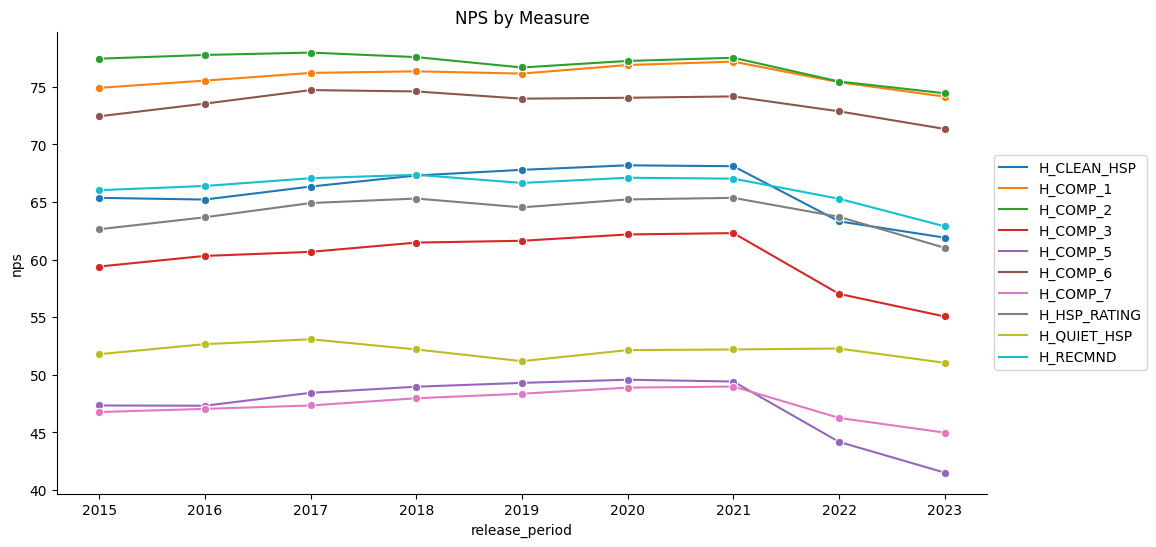

In [33]:
# NPS change over time by measure ID
plt.figure(figsize=(12, 6))
ax = sns.lineplot(data=state_results, x='release_period', y='nps', hue='measure_id', errorbar=None, marker='o')
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.title('NPS by Measure')
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
plt.show()

In [27]:
region = pd.read_csv('data_tables/states.csv')
region.columns = region.columns.str.lower().str.replace(' ', '_')

region.head()

,state,state_name,region
0,AK,Alaska,Pacific
1,AL,Alabama,East South Central
2,AR,Arkansas,West South Central
3,AZ,Arizona,Mountain
4,CA,California,Pacific


In [10]:
df_nps

,measure_id,state,2015,2016,2017,2018,2019,2020,2021,2022,2023,change_2016,change_2017,change_2018,change_2019,change_2020,change_2021,change_2022,change_2023
0,H_CLEAN_HSP,AK,62.0,65.0,64.0,67.0,63.0,67.0,62.0,62.0,69.0,3.0,-1.0,3.0,-4.0,4.0,-5.0,0.0,7.0
1,H_COMP_1,AK,65.0,74.0,73.0,75.0,76.0,74.0,74.0,74.0,77.0,9.0,-1.0,2.0,1.0,-2.0,0.0,0.0,3.0
2,H_COMP_2,AK,65.0,79.0,76.0,75.0,74.0,78.0,77.0,75.0,77.0,14.0,-3.0,-1.0,-1.0,4.0,-1.0,-2.0,2.0
3,H_COMP_3,AK,57.0,67.0,63.0,67.0,60.0,66.0,70.0,55.0,57.0,10.0,-4.0,4.0,-7.0,6.0,4.0,-15.0,2.0
4,H_COMP_5,AK,45.0,49.0,50.0,49.0,48.0,49.0,50.0,47.0,47.0,4.0,1.0,-1.0,-1.0,1.0,1.0,-3.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
505,H_COMP_6,WY,78.0,78.0,78.0,74.0,74.0,74.0,74.0,76.0,72.0,0.0,0.0,-4.0,0.0,0.0,0.0,2.0,-4.0
506,H_COMP_7,WY,47.0,47.0,48.0,51.0,50.0,51.0,52.0,49.0,49.0,0.0,1.0,3.0,-1.0,1.0,1.0,-3.0,0.0
507,H_HSP_RATING,WY,58.0,63.0,65.0,63.0,63.0,65.0,64.0,64.0,64.0,5.0,2.0,-2.0,0.0,2.0,-1.0,0.0,0.0
508,H_QUIET_HSP,WY,54.0,57.0,58.0,54.0,54.0,55.0,54.0,58.0,60.0,3.0,1.0,-4.0,0.0,1.0,-1.0,4.0,2.0


In [40]:
df_region = pd.merge(df_nps, region, on='state', how='left')
df_region.head()

,measure_id,state,2015,2016,2017,2018,2019,2020,2021,2022,2023,state_name,region
0,H_CLEAN_HSP,AK,62.0,65.0,64.0,67.0,63.0,67.0,62.0,62.0,69.0,Alaska,Pacific
1,H_COMP_1,AK,65.0,74.0,73.0,75.0,76.0,74.0,74.0,74.0,77.0,Alaska,Pacific
2,H_COMP_2,AK,65.0,79.0,76.0,75.0,74.0,78.0,77.0,75.0,77.0,Alaska,Pacific
3,H_COMP_3,AK,57.0,67.0,63.0,67.0,60.0,66.0,70.0,55.0,57.0,Alaska,Pacific
4,H_COMP_5,AK,45.0,49.0,50.0,49.0,48.0,49.0,50.0,47.0,47.0,Alaska,Pacific


In [50]:
years = df_region.columns[2:-2].tolist()
df_region.groupby('region')[years].mean()

,2015,2016,2017,2018,2019,2020,2021,2022,2023
region,,,,,,,,,
East North Central,65.120000,65.240000,65.900000,66.180000,65.580000,66.000000,65.900000,63.100000,60.940000
East South Central,64.175000,63.950000,64.650000,65.150000,64.725000,64.125000,64.350000,61.900000,60.675000
Mid-Atlantic,57.033333,56.633333,57.833333,58.100000,57.900000,57.833333,58.033333,55.733333,52.933333
Mountain,62.037500,62.875000,62.962500,63.037500,63.375000,64.237500,64.362500,61.875000,60.925000
New England,63.366667,63.166667,64.416667,63.966667,63.600000,64.333333,64.216667,61.450000,58.583333
Pacific,60.060000,61.640000,61.960000,61.620000,61.720000,63.220000,62.900000,59.940000,58.720000
South Atlantic,58.411111,58.977778,59.500000,60.255556,59.622222,59.755556,60.044444,56.966667,54.711111
West North Central,66.642857,67.800000,69.214286,69.514286,69.128571,70.000000,70.142857,68.457143,66.585714
West South Central,65.050000,65.600000,66.350000,67.025000,66.575000,66.850000,67.025000,63.650000,63.525000


## nps score?
nps score difference between 2023 and 2021

states with lowest score
what measure ID is worst? best?

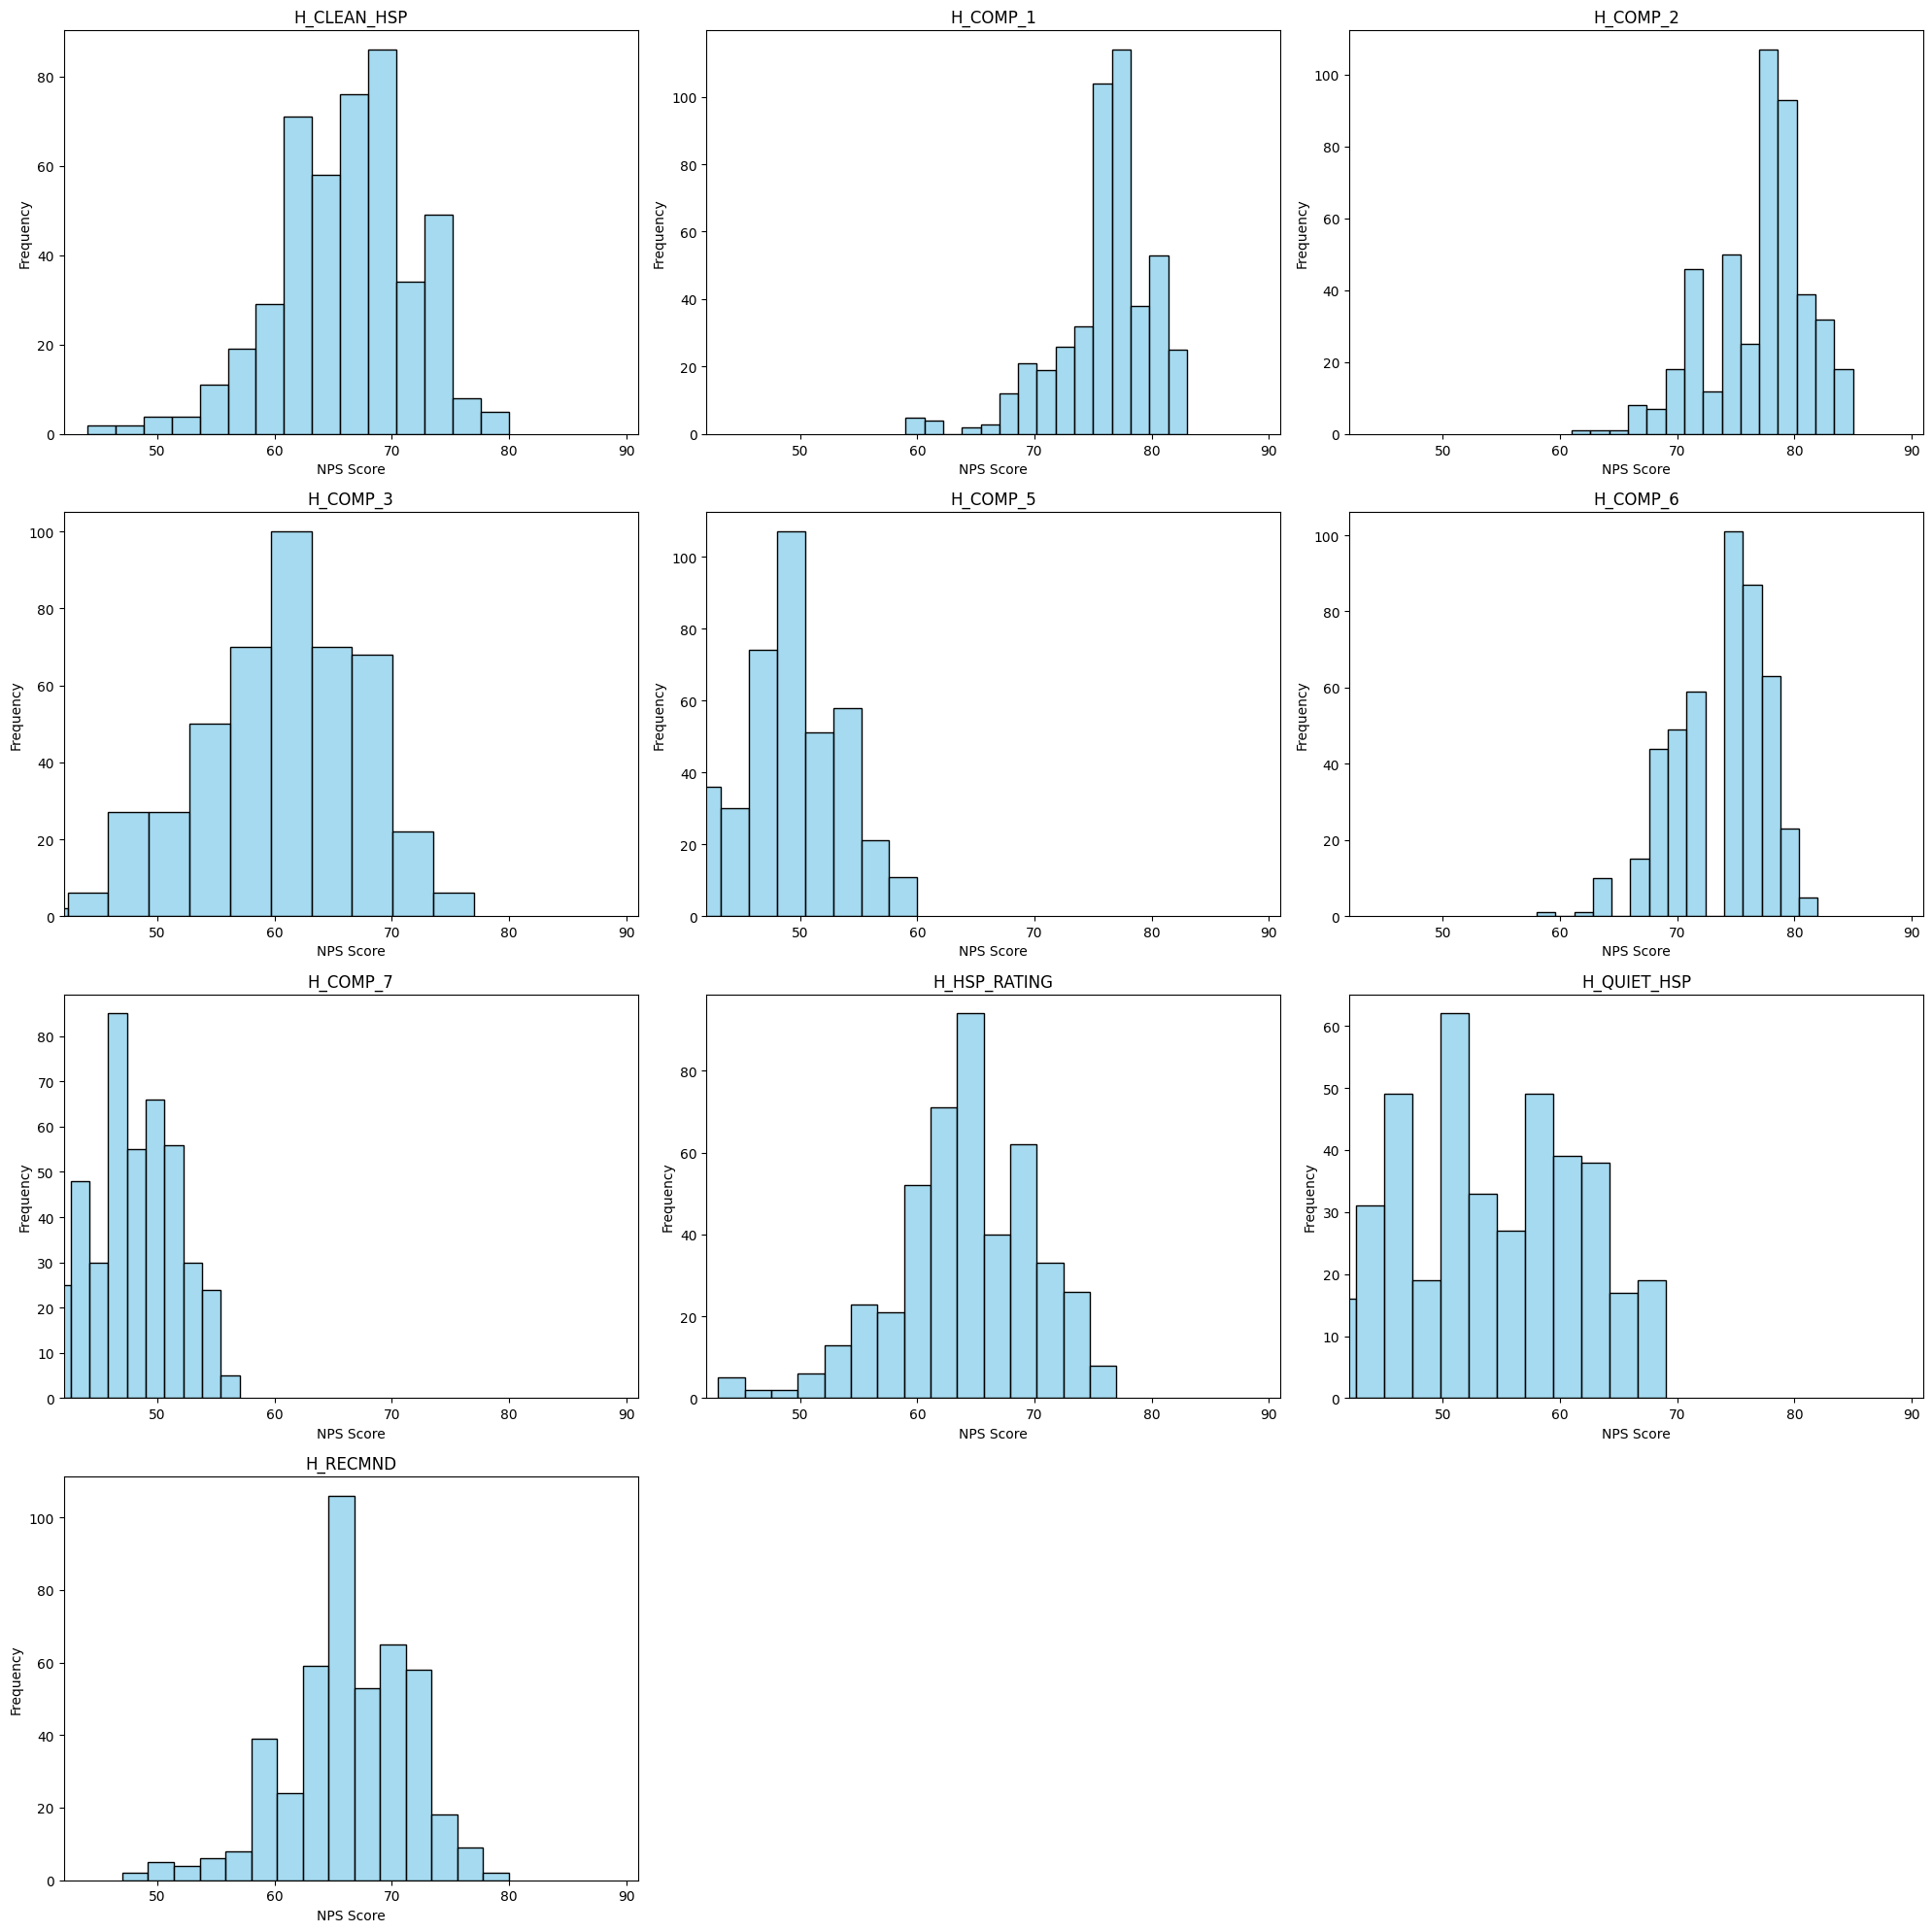

In [12]:
# Get unique measure IDs
measure_ids = statey['Measure ID'].unique()
x_min = statey['Top-box Percentage'].min()
x_max = statey['Top-box Percentage'].max()

# Number of rows and columns for the subplots
n_rows = (len(measure_ids) + 2) // 3  # Assuming 3 columns for layout
n_cols = 3

# Initialize the figure
plt.figure(figsize=(20, 5 * n_rows))

# Plot histograms for each measure ID
for index, measure in enumerate(measure_ids):
    plt.subplot(n_rows, n_cols, index + 1)
    sns.histplot(statey[statey['Measure ID'] == measure]['nps'], kde=False, bins=15, color='skyblue')
    plt.title(measure)
    plt.xlim(x_min, x_max)
    plt.xlabel('NPS Score')
    plt.ylabel('Frequency')

plt.tight_layout()
plt.show()


## State Average Score

In [4]:
# Group by by release period and state; filter for 2023
state_scores = state_results.groupby(['Release Period', 'State'])['Top-box Percentage'].mean().reset_index()
state_scores = state_scores[state_scores['Release Period'] == '2023-01-01']


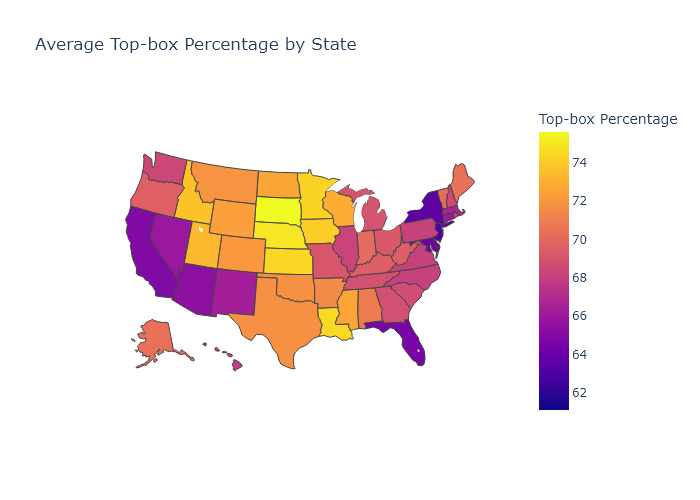

In [5]:
# Plot average top-box percentage by state
fig = px.choropleth(state_scores, 
                    color='Top-box Percentage', 
                    locations='State', 
                    locationmode='USA-states', 
                    title= 'Average Top-box Percentage by State',
                    scope='usa',
                    color_continuous_scale='Plasma',)

fig.show(renderer='png')


## State measure ID count

## Responses
We will look at the responses of the surveys

A total of 56 unique states were found. 5 States (PR, VI, GU, MP, AS) were not part of the US. Further research revealed that the US had 5 unincorporated territories: American Samoa, Guam, the Northern Mariana Islands, Puerto Rico, and the U.S. Virgin Islands. This explains the extra 5 states found in the data which were removed. 

The `completed_surveys` column contained both numberic and categorical (Not Available, 300 or more, Between 100 and 299, Fewer than 100, Fewer than 50) data. According to the HCAHPS website, hospitals must obtain at least 300 completed HCAHPS Surveys over a 12-month reporting period and therefore the cateforical data was dropped. 

In [6]:
responses = dataframes['responses']
responses['Release Period'] = pd.to_datetime(responses['Release Period'].str.lstrip('07_'))
responses.columns = [col.lower().replace(' ', '_') for col in responses.columns]
responses.rename(columns={'response_rate_(%)': 'response_rate'}, inplace=True)

states = dataframes['states']

responses.head()

,release_period,state,facility_id,completed_surveys,response_rate
0,07_2015,AL,10001,300 or more,27
1,07_2015,AL,10005,300 or more,37
2,07_2015,AL,10006,300 or more,25
3,07_2015,AL,10007,Between 100 and 299,30
4,07_2015,AL,10008,Fewer than 100,28


In [68]:
responses.describe(include='all')

,Release Period,State,Facility ID,Completed Surveys,Response Rate (%)
count,43219,43219,43219,43219,43219
unique,NaN,56,5251,3387,85
top,NaN,TX,10001,Not Available,Not Available
freq,NaN,3562,9,5772,5774
mean,2019-01-14 08:44:18.164233472,NaN,NaN,NaN,NaN
min,2015-01-01 00:00:00,NaN,NaN,NaN,NaN
25%,2017-01-01 00:00:00,NaN,NaN,NaN,NaN
50%,2019-01-01 00:00:00,NaN,NaN,NaN,NaN
75%,2021-01-01 00:00:00,NaN,NaN,NaN,NaN
max,2023-01-01 00:00:00,NaN,NaN,NaN,NaN


In [9]:
# Find extra 5 states
responses[~responses['state'].isin(states['State'])].state.value_counts()

state
PR    470
VI     18
GU     16
MP      9
AS      7
Name: count, dtype: int64

In [10]:
# Drop extra 5 states
responses = responses[responses['state'].isin(states['State'])]


In [110]:
responses[responses.completed_surveys.str.contains('[a-zA-Z]', regex=True) == True].completed_surveys.value_counts()

completed_surveys
Not Available          5294
300 or more            2770
FEWER THAN 50           853
Between 100 and 299     776
Fewer than 100          612
Name: count, dtype: int64

In [109]:
responses.completed_surveys.value_counts()

completed_surveys
Not Available          5294
300 or more            2770
FEWER THAN 50           853
Between 100 and 299     776
Fewer than 100          612
                       ... 
2803                      1
5445                      1
2312                      1
3411                      1
4186                      1
Name: count, Length: 3387, dtype: int64

In [138]:
responses = responses[responses.completed_surveys.str.contains('[a-zA-Z]', regex=True) == False]
responses

,release_period,state,facility_id,completed_surveys,response_rate
4656,2016-01-01,AL,10001,1305,28
4657,2016-01-01,AL,10005,616,35
4658,2016-01-01,AL,10006,372,24
4659,2016-01-01,AL,10007,271,32
4660,2016-01-01,AL,10008,76,32
...,...,...,...,...,...
43207,2023-01-01,TX,670143,42,28
43208,2023-01-01,TX,670259,34,34
43209,2023-01-01,TX,670260,454,14
43214,2023-01-01,TX,670300,186,15


In [140]:
responses.completed_surveys = responses.completed_surveys.astype(int)
responses[responses.completed_surveys <= 300]

C:\Users\Andy\AppData\Local\Temp\ipykernel_2268\2370602729.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



,release_period,state,facility_id,completed_surveys,response_rate
4659,2016-01-01,AL,10007,271,32
4660,2016-01-01,AL,10008,76,32
4666,2016-01-01,AL,10021,246,30
4667,2016-01-01,AL,10022,94,37
4671,2016-01-01,AL,10032,89,35
...,...,...,...,...,...
43206,2023-01-01,TX,670136,73,16
43207,2023-01-01,TX,670143,42,28
43208,2023-01-01,TX,670259,34,34
43214,2023-01-01,TX,670300,186,15


In [22]:
df = responses[responses['release_period'] == '2023-01-01']
df

,release_period,state,facility_id,completed_surveys,response_rate
38381,2023-01-01,AL,10001,482,15
38382,2023-01-01,AL,10005,773,17
38383,2023-01-01,AL,10006,1385,18
38384,2023-01-01,AL,10007,171,23
38385,2023-01-01,AL,10008,38,22
...,...,...,...,...,...
43214,2023-01-01,TX,670300,186,15
43215,2023-01-01,TX,670309,164,12
43216,2023-01-01,TX,670310,Not Available,Not Available
43217,2023-01-01,TX,670314,Not Available,Not Available


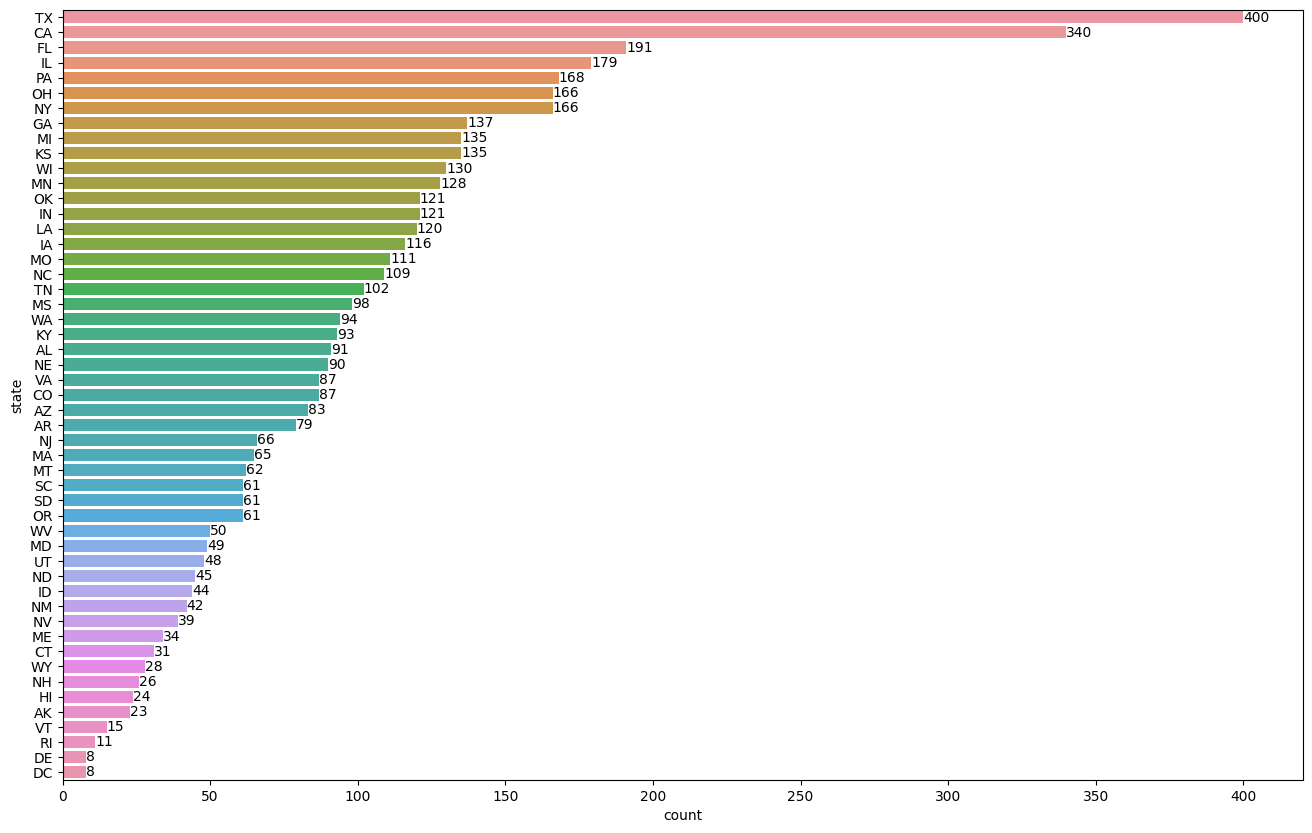

In [30]:
plt.figure(figsize=(16, 10))
ax = sns.countplot(data=df,
              y='state',
              order=df['state'].value_counts().index)
for label in ax.containers:
    ax.bar_label(label)
plt.show()